interva: 1
learnは0.015625999999997475秒かかりました
average_error: 1.70060640175485
max_error : 10.340126131865675

interva: 2
learnは0.024897500000008677秒かかりました
average_error: 1.7023722906531704
max_error : 10.061082720669853

interva: 3
learnは0.021144900000024336秒かかりました
average_error: 1.6893152528738498
max_error : 8.63207521803523

interva: 4
learnは0.01801150000000007秒かかりました
average_error: 1.6802706453665945
max_error : 8.788377415350194

interva: 5
learnは0.023608000000024276秒かかりました
average_error: 1.674131994727893
max_error : 8.326624006880916

interva: 6
learnは0.023913900000025023秒かかりました
average_error: 1.6640684971954263
max_error : 8.471949619908482

interva: 7
learnは0.025270499999976437秒かかりました
average_error: 1.6558256818369594
max_error : 8.520232197279046

interva: 8
learnは0.018284300000004805秒かかりました
average_error: 1.637110563094247
max_error : 8.520927000517798

interva: 9
learnは0.01931819999998652秒かかりました
average_error: 1.6495709616999001
max_error : 8.702918119871036

interva: 10
lea

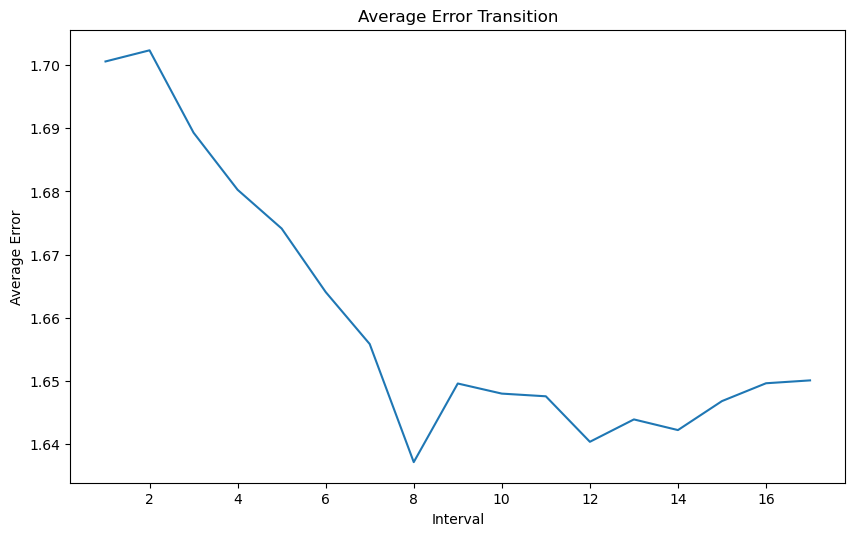

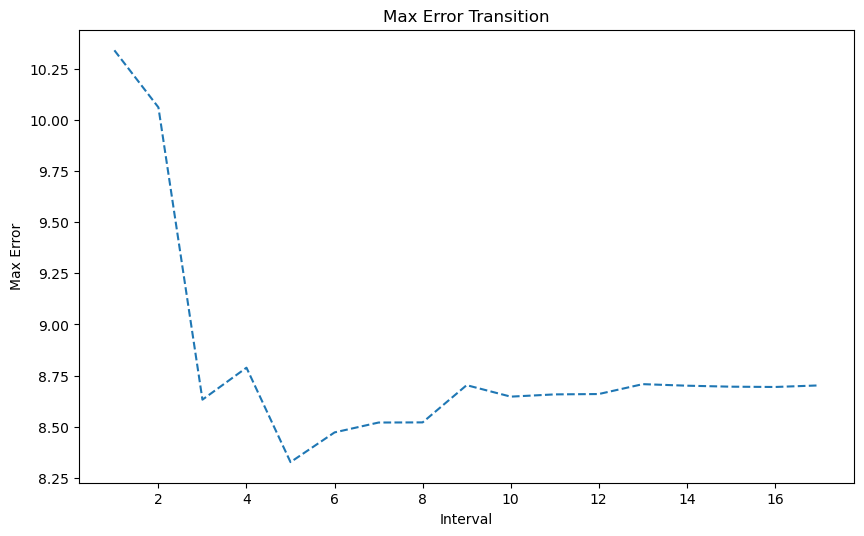

In [4]:
"""
10年分の平均気温から学習し、interval日間の過去のデータから、次の日の平均気温を予測するプログラム

Notes
-----
・元のプログラムで作成されている"kion10y.csv"と同じ形式のCSVファイルを前提としています。
    一応、異なる西暦がセットされたデータを用いて軽くチェックは行っていますが、
    ダウンロードしたファイルと期間次第ではエラーを吐くかもしれません。

・最終的に学習結果のうち、平均誤差と最大誤差を、インターバルごとにプロットしたグラフをoutput_imageフォルダ内に保存します
    画像の保存を避けたい場合は、198行目と206行目のplt.savefigをコメントアウトしてください

・実行時間の報告が鬱陶しい場合は、127行目learn関数の上にある@count_timeをコメントアウトしてください

・平均誤差と最大誤差の報告が鬱陶しい場合は、154行目report関数の中にあるprint文をコメントアウトしてください
"""
from functools import wraps
import os
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


# CSVファイル名(同階層前提)
CSV_FILE_NAME = "kion10y.csv"
# 分割する年
CUT_YEAR = 2015
# 画像ファイル出力先フォルダ
OUTPUT_DIRECTORY = "output_image"


def count_time(func):
    """
    プログラムの実行時間を計測するラッパー関数
    
    Parameters
    ----------
    func : function
        実行時間を計測したい関数
    """
    @wraps(func)
    def wrapper(*args, **kargs):
        start = perf_counter()
        result = func(*args, **kargs)
        elapsed_time = perf_counter() - start
        print(f"{func.__name__}は{elapsed_time}秒かかりました")
        return result
    return wrapper


class WeatherPrediction:
    """
    天気のデータを格納し、過去のデータから未来の天気を予測
    
    Attributes
    ----------
    _weather_df : pandas.core.frame.DataFrame
        日毎の気温が格納されたデータフレーム
    _average_error : float
        最終的に返す平均の誤差
    _max_error : float
        最終的に返す最大の誤差
    """

    def __init__(self, csv_file_name):
        """
        Parameters
        ----------
        csv_file_name : str
            天気のデータが格納されたCSVファイル
        """
        self._weather_df =  pd.read_csv(csv_file_name, encoding='utf-8')
        
        self._average_error = 0
        self._max_error = 0

    def _divide_df(self, cut_year):
        """
        指定された年以前と、それより後の年をそれぞれ学習用とテスト用に分割
        
        Parameter
        ---------
        cut_year : int
            分割にしたい基準の西暦
        
        Return
        ------
        (train_year_df, test_year_df) : tuple
            分割したデータフレームが含まれたタプル
        """
        train_year = (self._weather_df["年"] <= cut_year)
        test_year = (self._weather_df["年"] > cut_year)
        
        train_year_df = self._weather_df[train_year]
        test_year_df = self._weather_df[test_year]
        
        return (train_year_df, test_year_df)
    
    def _make_data(self, temps_df, interval):
        """
        インターバルに応じてデータフレームを予測したいデータと予測に用いるデータに分割
        
        Parameter
        ---------
        temps_ldf : pandas.DataFrame
            分割したい温度のデータフレーム
        
        interval : int
            予測に用いるデータの個数
        
        Returns
        -------
        (train_data, result) : tuple
            予測データと予測結果のリストが含まれたタプル
        """
        train_data = []
        result_data = []
        temps_list = list(temps_df["気温"])
        
        for i in range(interval, len(temps_list)):
            result_data.append(temps_list[i])
            train_data.append(temps_list[i-interval:i])
        
        return (train_data, result_data)
    
    @count_time
    def learn(self, interval, cut_year):
        """
        インターバルと分割する年を指定して学習モデルを構築
        
        Attributes
        ----------
        interval : int
            予測に使用するデータの個数
        cut_year : int
            分割に使用したい基準の西暦
        """
        train_year_df, test_year_df = self._divide_df(cut_year)
        
        train_x_list, train_y_list = self._make_data(train_year_df, interval)
        test_x_list, test_y_list = self._make_data(test_year_df, interval)
        
        lr = LinearRegression(normalize=True)
        lr.fit(train_x_list, train_y_list)
        pre_y_array = lr.predict(test_x_list)
        diff_y_array = abs(pre_y_array - test_y_list)
        average_error = sum(diff_y_array) / len(diff_y_array)
        max_error = max(diff_y_array)
        
        self._average_error = average_error
        self._max_error = max_error
    
    def report(self):
        """
        学習結果を外部に報告する
        
        Returns
        -------
        self._average_error : float
            誤差の平均
        self._max_error : float
            最大の誤差
        """
        print(f"average_error: {self._average_error}")
        print(f"max_error : {self._max_error}")
        return self._average_error, self._max_error


weather_predictor = WeatherPrediction(CSV_FILE_NAME)
x_list = []
average_error_list = []
max_error_list = []

for i in range(1, 18):
    print(f"interva: {i}")
    weather_predictor.learn(interval=i, cut_year=CUT_YEAR)
    average_error, max_error = weather_predictor.report()
    print("")
    
    x_list.append(i)
    average_error_list.append(average_error)
    max_error_list.append(max_error)

x_array = np.array(x_list)
average_error_array = np.array(average_error_list)
max_error_array = np.array(max_error_list)

# フォルダがない場合作成
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(x_array, average_error_array, linestyle="solid")
plt.title("Average Error Transition")
plt.xlabel("Interval")
plt.ylabel("Average Error")
plt.savefig(f'./{OUTPUT_DIRECTORY}/AverageError{CUT_YEAR}.png')
plt.show()

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(x_array, max_error_array, linestyle="dashed")
plt.title("Max Error Transition")
plt.xlabel("Interval")
plt.ylabel("Max Error")
plt.savefig(f'./{OUTPUT_DIRECTORY}/MaxError{CUT_YEAR}.png')
